# Can I predict how much people will spend online?
### Insights from Google Analytics data


In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('mergedGAdata.csv')
print(df.shape)

(3532, 16)


# Wrangling

In [141]:
##Turn Session Duration into numbers not strings
print(type(df['Session Duration'][0]))
df['Session Duration'] = df['Session Duration'].str.replace(' seconds','')

df['Session Duration'] = pd.to_numeric(df['Session Duration'])
print(type(df['Session Duration'][0]))

#display(df.head(5))

<class 'str'>
<class 'numpy.int64'>


In [142]:
### Dropping an unneccesary column
df = df.drop(columns=['Unnamed: 0'])

###Turn dates into datetime objects
print(type(df['Date'][0]))
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
##Checking to make sure it worked
print(type(df['Date'][0]))

df['Year']= df['Date'].dt.year
df['Month']= df['Date'].dt.month
df['Day']= df['Date'].dt.day

df['Day_of_year'] = ((df['Month']*30.333-30).round(0) + df['Day'])



#X_train['year'] = X_train['date_cleaned'].dt.year

## Get rid of a pesky NaN in the final observation
df.drop(df.tail(1).index,inplace=True)

print(df.shape)

#df.head(30)

<class 'numpy.int64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
(3531, 19)


In [143]:
## Drop transaction ID
df = df.drop(columns=['Transaction ID'])

## Dropping the datetime object becuase it breaks my Random Forest
df = df.drop(columns=['Date'])

# Exploratory Visualizations

In [144]:

fig = px.bar(df, x='Day_of_year', y='Revenue', 
                 #color="Session Duration"
                )
fig.show()

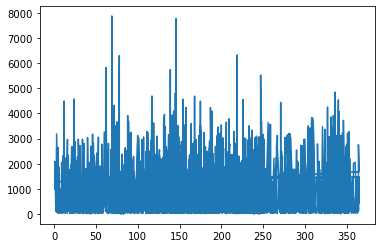

In [145]:
matplotlib_figure = plt.figure()
x = df['Day_of_year']
y = df['Revenue']
plt.plot(x, y);

In [146]:
from plotly.tools import mpl_to_plotly
plotly_figure = mpl_to_plotly(matplotlib_figure)
plotly_figure.show()

In [147]:
import plotly.express as px
fig = px.scatter(df, x='Page Depth', y='Revenue', 
                 #color="Session Duration"
                )

fig.show()

# Building a model

In [148]:
## Checking to make sure none of my data types will break the models
df.dtypes

Country                     object
City                        object
Session Duration             int64
Revenue                    float64
User Type                   object
Region                      object
Metro                       object
Day of Week                float64
Days to Transaction        float64
Days Since Last Session    float64
Device Category             object
Count of Sessions          float64
Page Depth                 float64
Year                         int64
Month                        int64
Day                          int64
Day_of_year                float64
dtype: object

# Break into Test/Train 

In [149]:
from sklearn.model_selection import train_test_split

In [150]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              #stratify=df['Product'], 
                               random_state=42)

print(train.shape)
test.shape

(2824, 17)


(707, 17)

In [151]:
# Arrange data into X features matrix and y target vector
target = 'Revenue'

#model_deploy = ['Day_of_year', 'Page Depth', 'Session Duration']
X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

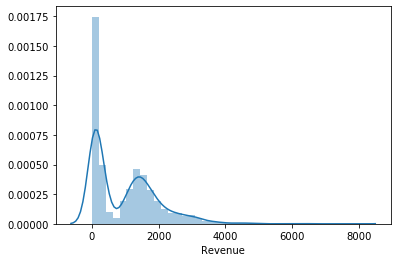

In [152]:
sns.distplot(y_train);
## My target variable, 'Revenue' has quite a bimodal distribution

# Baselines


In [153]:
from sklearn.metrics import mean_absolute_error
price = df['Revenue']
best_guess = price.mean()
best_guess = [best_guess] * len(price)
baseline_mae = mean_absolute_error(price, best_guess)
print(f'The Baseline mean absolute error is ${baseline_mae.round(2)}')

The Baseline mean absolute error is $813.25


## A Linear Regression

In [154]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_test, y_test))

y_pred = lr.predict(X_test)
print(f'The Baseline mean absolute error is ${baseline_mae.round(2)}')
mae = mean_absolute_error(y_test, y_pred)
print(f'The linear regression mean absolute error is ${mae.round(2)}')


Linear Regression R^2 0.0005382190419163102
The Baseline mean absolute error is $813.25
The linear regression mean absolute error is $759.96


In [155]:
'''
RESULTS
Pass 1
Linear Regression R^2 -0.00442905637790969
Gradient Boosting R^2 -0.023036898195452293

Pass2
Linear Regression R^2 -0.004429056377912577
Gradient Boosting R^2 0.07102524633751028

Pass3
Linear Regression R^2 0.002162738520710472
Gradient Boosting R^2 0.08770212107051312

Pass4 (with only 3 features)
Linear Regression R^2 0.02979757194722665
Gradient Boosting R^2 0.076352681199784

Pass5 (with all features)
Linear Regression R^2 0.0005382190419163102
Gradient Boosting R^2 0.07698263724426613
'''

'\nRESULTS\nPass 1\nLinear Regression R^2 -0.00442905637790969\nGradient Boosting R^2 -0.023036898195452293\n\nPass2\nLinear Regression R^2 -0.004429056377912577\nGradient Boosting R^2 0.07102524633751028\n\nPass3\nLinear Regression R^2 0.002162738520710472\nGradient Boosting R^2 0.08770212107051312\n\nPass4 (with only 3 features)\nLinear Regression R^2 0.02979757194722665\nGradient Boosting R^2 0.076352681199784\n\nPass5 (with all features)\nLinear Regression R^2 0.0005382190419163102\nGradient Boosting R^2 0.07698263724426613\n'

# XGBoost Model

In [156]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(objective='reg:squarederror')
)


param_distributions = {
    'xgbregressor__n_estimators': randint(50, 500)
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


search.fit(X_train, y_train)


print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)


pipeline = search.best_estimator_


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Gradient Boosting R^2', r2_score(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

print(f'The Baseline mean absolute error is ${baseline_mae.round(2)}')
print(f'Model MAE ${mae.round(2)}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   27.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.4s finished


Best hyperparameters {'xgbregressor__n_estimators': 117}
Cross-validation MAE 710.8995994328072
Gradient Boosting R^2 0.10435164459146773
The Baseline mean absolute error is $813.25
Model MAE $703.98


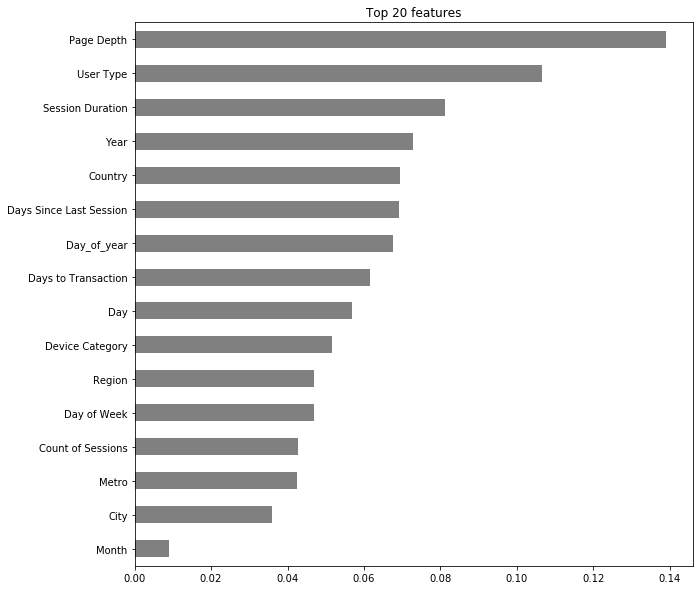

In [157]:
# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Permutation Importances

In [158]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    #SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

[09:04:48] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [159]:
# Ignore warnings

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    #scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=100, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=42, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [160]:
feature_names = X_test.columns.tolist()
#pd.Series(permuter.feature_importances_, feature_names).sort_values()

In [161]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names) # must be a list

Weight,Feature
0.1004 ± 0.0181,Page Depth
0.0824 ± 0.0218,Session Duration
0.0365 ± 0.0293,Day_of_year
0.0137 ± 0.0077,Year
0.0108 ± 0.0102,User Type
0.0107 ± 0.0069,Country
0.0100 ± 0.0114,Region
0.0074 ± 0.0037,Device Category
0.0058 ± 0.0123,Days Since Last Session
0.0030 ± 0.0041,Day


# Partial dependence plot

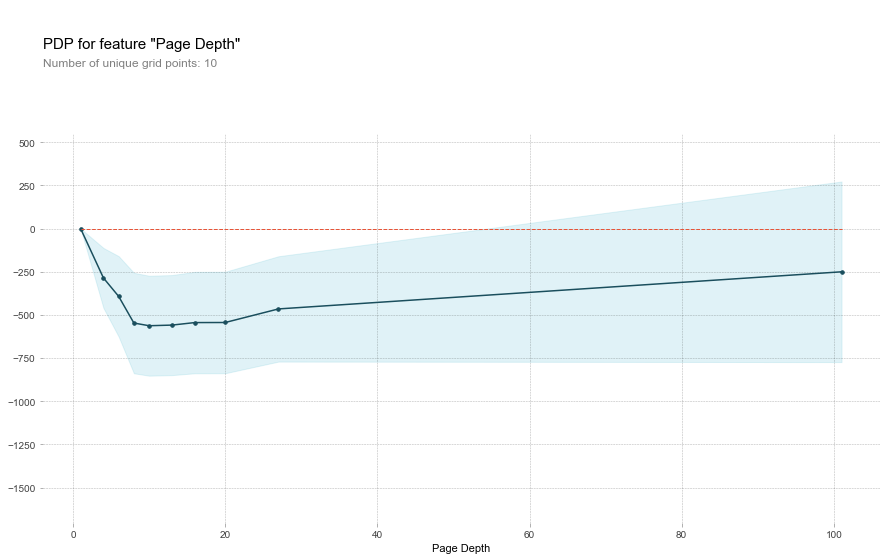

In [162]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Page Depth'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature)
pdp_plot(isolated, feature_name=feature);

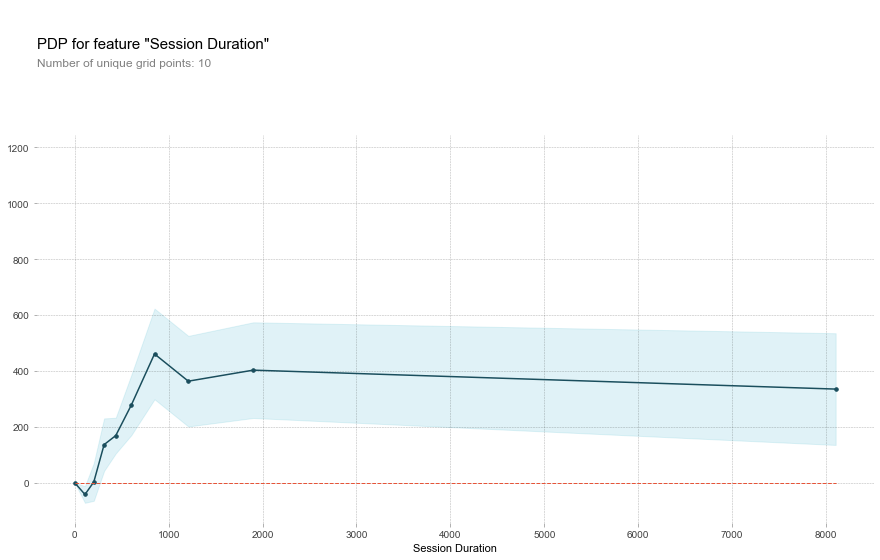

In [163]:
feature = 'Session Duration'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature)
pdp_plot(isolated, feature_name=feature);

In [164]:
feature = 'Day_of_year'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature)

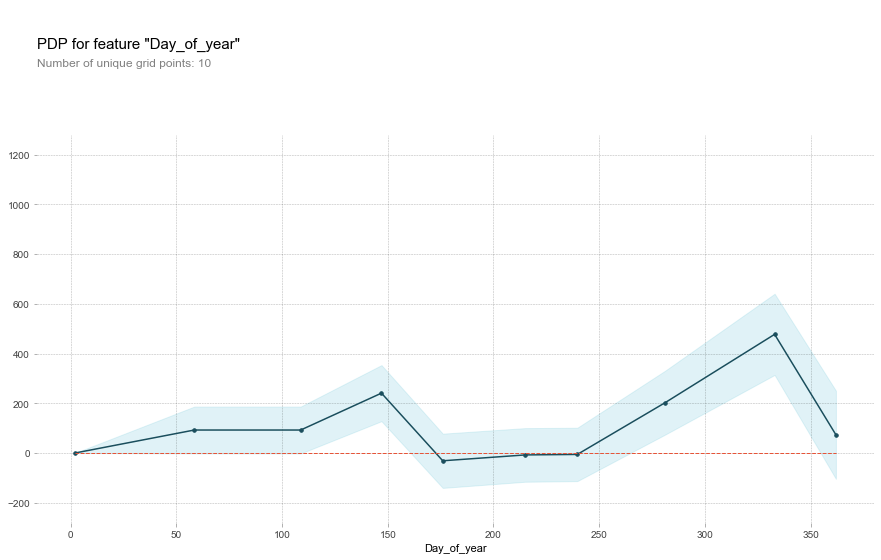

In [165]:
pdp_plot(isolated, feature_name=feature);

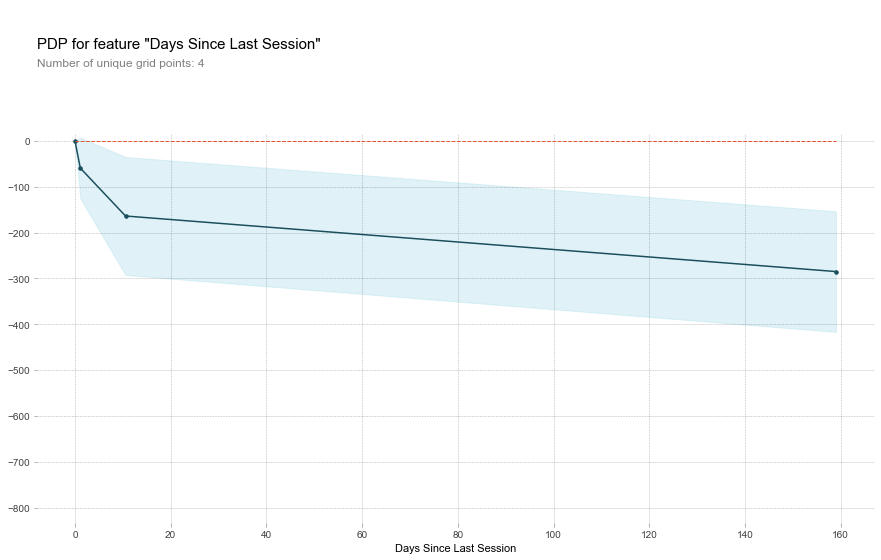

In [166]:

feature = 'Days Since Last Session'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature)
pdp_plot(isolated, feature_name=feature);



# Rebuilding the model with only a few features
### This is so I can deploy a much simpler model with fewer sliders on Heroku


In [167]:
# Arrange data into X features matrix and y target vector
target = 'Revenue'

model_deploy = ['Day_of_year', 'Page Depth', 'Session Duration']
X_train = train[model_deploy]
y_train = train[target]

X_test = test[model_deploy]
y_test = test[target]

In [168]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(objective='reg:squarederror')
)


param_distributions = {
    'xgbregressor__n_estimators': randint(50, 500)
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


search.fit(X_train, y_train)


print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)


pipeline = search.best_estimator_


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Gradient Boosting R^2', r2_score(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

print(f'The Baseline mean absolute error is ${baseline_mae.round(2)}')
print(f'Model MAE ${mae.round(2)}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


Best hyperparameters {'xgbregressor__n_estimators': 128}
Cross-validation MAE 728.7534482904509
Gradient Boosting R^2 0.0851985114049737
The Baseline mean absolute error is $813.25
Model MAE $723.99


# Exporting a .joblib file for my Heroku model

In [169]:
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [170]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')


joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.1.0
xgboost==0.90


# Further data exploration- things I could do:

### Add in more features by exporting more csv's from Google Analytics

### Make more visualizations

### Try replacing 0's in 'session duration' with NaNs

### Make some kind of feature that describes if a product was purchased together with another product.
(This psuedocode could tell if somebody placed a follow up order the same day)

if (df['Date'][i]==df['Date'][i+1]) & (df['Transaction ID'][i]==df['Transaction ID']+1[i+1]):
    return True
